## Online News Popularity Prediction

In [1]:
import os
import calendar
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import randint, spearmanr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from deap import base, creator, tools, algorithms
from sklearn.neural_network import MLPClassifier
from skopt.space import Real, Integer, Categorical
from sklearn.inspection import permutation_importance

# from sklearn import tree

DATA_PATH = "OnlineNewsPopularity/OnlineNewsPopularity.csv"

In [2]:
def load_data(file_path, sheet_name=None):
    """
    Load spreadsheet data into a dataframe from given path.

    Args:
        file_path (str): the path to the spreadsheet file
        sheet_name (str): name of the sheet in the spreadsheet

    Returns:
        pd.DataFrame: the dataframe containing the spreadsheet data
    """
    file_extension = os.path.splitext(file_path)[1]
    if file_extension == '.csv':
        return pd.read_csv(file_path)
    elif file_extension == '.xls':
        return pd.read_excel(file_path, sheet_name=sheet_name)
    else:
        print("The file is neither an Excel file nor a CSV file.")

df = load_data(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [3]:
df.columns = df.columns.str.strip()
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

## Data Cleaning

In [4]:
df = df.dropna(axis=1)

In [5]:
# Drop rows where article content have no text
df = df.loc[df['n_tokens_content'] != 0]

In [6]:
df.drop(['url', 'timedelta',
        ],
        axis='columns',
        inplace=True,
        errors='ignore')
df.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,...,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000
mean,10.382419,563.295375,0.565049,1.027065,0.710336,11.217872,3.394769,4.563061,1.263786,4.687892,...,0.098376,0.779963,-0.267493,-0.537970,-0.110801,0.280573,0.070997,0.342431,0.154930,3355.360398
std,2.113800,468.299538,3.573022,5.307978,3.312293,11.340580,3.869773,8.295365,4.164896,0.283231,...,0.070382,0.212509,0.121174,0.279703,0.094919,0.323561,0.264338,0.188606,0.225636,11585.968776
min,2.000000,18.000000,0.114964,1.000000,0.119134,0.000000,0.000000,0.000000,0.000000,3.600000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,259.000000,0.477419,1.000000,0.632588,5.000000,1.000000,1.000000,0.000000,4.496250,...,0.050000,0.600000,-0.331532,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000,945.000000
50%,10.000000,423.000000,0.542986,1.000000,0.693727,8.000000,3.000000,1.000000,0.000000,4.674121,...,0.100000,0.800000,-0.257738,-0.500000,-0.100000,0.125000,0.000000,0.500000,0.000000,1400.000000
75%,12.000000,729.000000,0.611111,1.000000,0.756944,14.000000,4.000000,4.000000,1.000000,4.861901,...,0.100000,1.000000,-0.193415,-0.312500,-0.050000,0.500000,0.136364,0.500000,0.250000,2700.000000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


## Data Visualization

### Combine One-hot Encoded Columns

In [7]:
tmp_df = df.copy()
tmp = tmp_df.filter(regex='data_channel_is_')

In [8]:
tmp_data = tmp.values
raw_indices = tmp_data.argmax(axis=1)
zero_mask = (tmp_data == 0).all(axis=1)
corrected_indices = np.where(zero_mask, -1, raw_indices)

channel_columns = tmp.filter(regex='data_channel_is_').columns
channel_columns = pd.Index(['no_data_channel'] + channel_columns.tolist())

tmp_df.loc[:, 'data_channel'] = 0
tmp_df.loc[corrected_indices != -1, 'data_channel'] = corrected_indices[corrected_indices != -1] + 1
t = tmp_df.filter(regex='data_channel_is_').columns

tmp_df.drop(channel_columns, axis='columns', inplace=True, errors='ignore')

In [9]:
tmp_data = tmp.values
raw_indices = tmp_data.argmax(axis=1)
zero_mask = (tmp_data == 0).all(axis=1)
corrected_indices = np.where(zero_mask, -1, raw_indices)

tmp_df.loc[:, 'day_of_week'] = 0
tmp_df.loc[corrected_indices != -1, 'day_of_week'] = corrected_indices[corrected_indices != -1] + 1
tmp_df.drop(tmp_df.filter(regex='weekday_is_').columns, axis='columns', inplace=True)

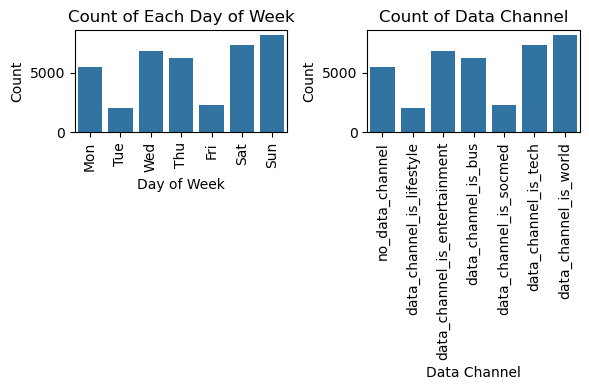

In [10]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

weekday_names = list(calendar.day_abbr)[:7]
counts = tmp_df['day_of_week'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
axes[0].set_xticks(ticks=range(7), labels=weekday_names, rotation=90) 
axes[0].set_xlabel("Day of Week")
axes[0].set_ylabel("Count")
axes[0].set_title("Count of Each Day of Week")

counts = tmp_df['data_channel'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values, ax=axes[1])
axes[1].set_xticks(ticks=range(7), labels=channel_columns, rotation=90) 
axes[1].set_xlabel("Data Channel")
axes[1].set_ylabel("Count")
axes[1].set_title("Count of Data Channel")

plt.tight_layout()
plt.show()

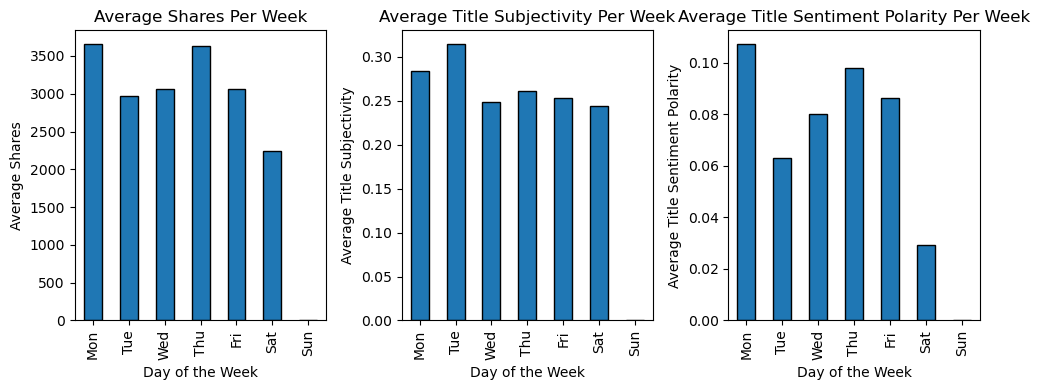

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

day_map = { idx+1: name for idx, name in enumerate(weekday_names) }

tmp_df['day'] = tmp_df['day_of_week'].map(day_map)
df_avg = tmp_df.groupby('day')['shares'].mean().reindex(day_map.values())
df_avg.plot(ax=axes[0], kind='bar', edgecolor='black')
axes[0].set_title('Average Shares Per Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Average Shares')

# tmp_df['day'] = tmp_df['day_of_week'].map(day_map)
df_avg = tmp_df.groupby('day')['title_subjectivity'].mean().reindex(day_map.values())
df_avg.plot(ax=axes[1], kind='bar', edgecolor='black')
axes[1].set_title('Average Title Subjectivity Per Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Average Title Subjectivity')

df_avg = tmp_df.groupby('day')['title_sentiment_polarity'].mean().reindex(day_map.values())
df_avg.plot(ax=axes[2], kind='bar', edgecolor='black')
axes[2].set_title('Average Title Sentiment Polarity Per Week')
axes[2].set_xlabel('Day of the Week')
axes[2].set_ylabel('Average Title Sentiment Polarity')

plt.tight_layout()
plt.show()

### Graph Data Distribution

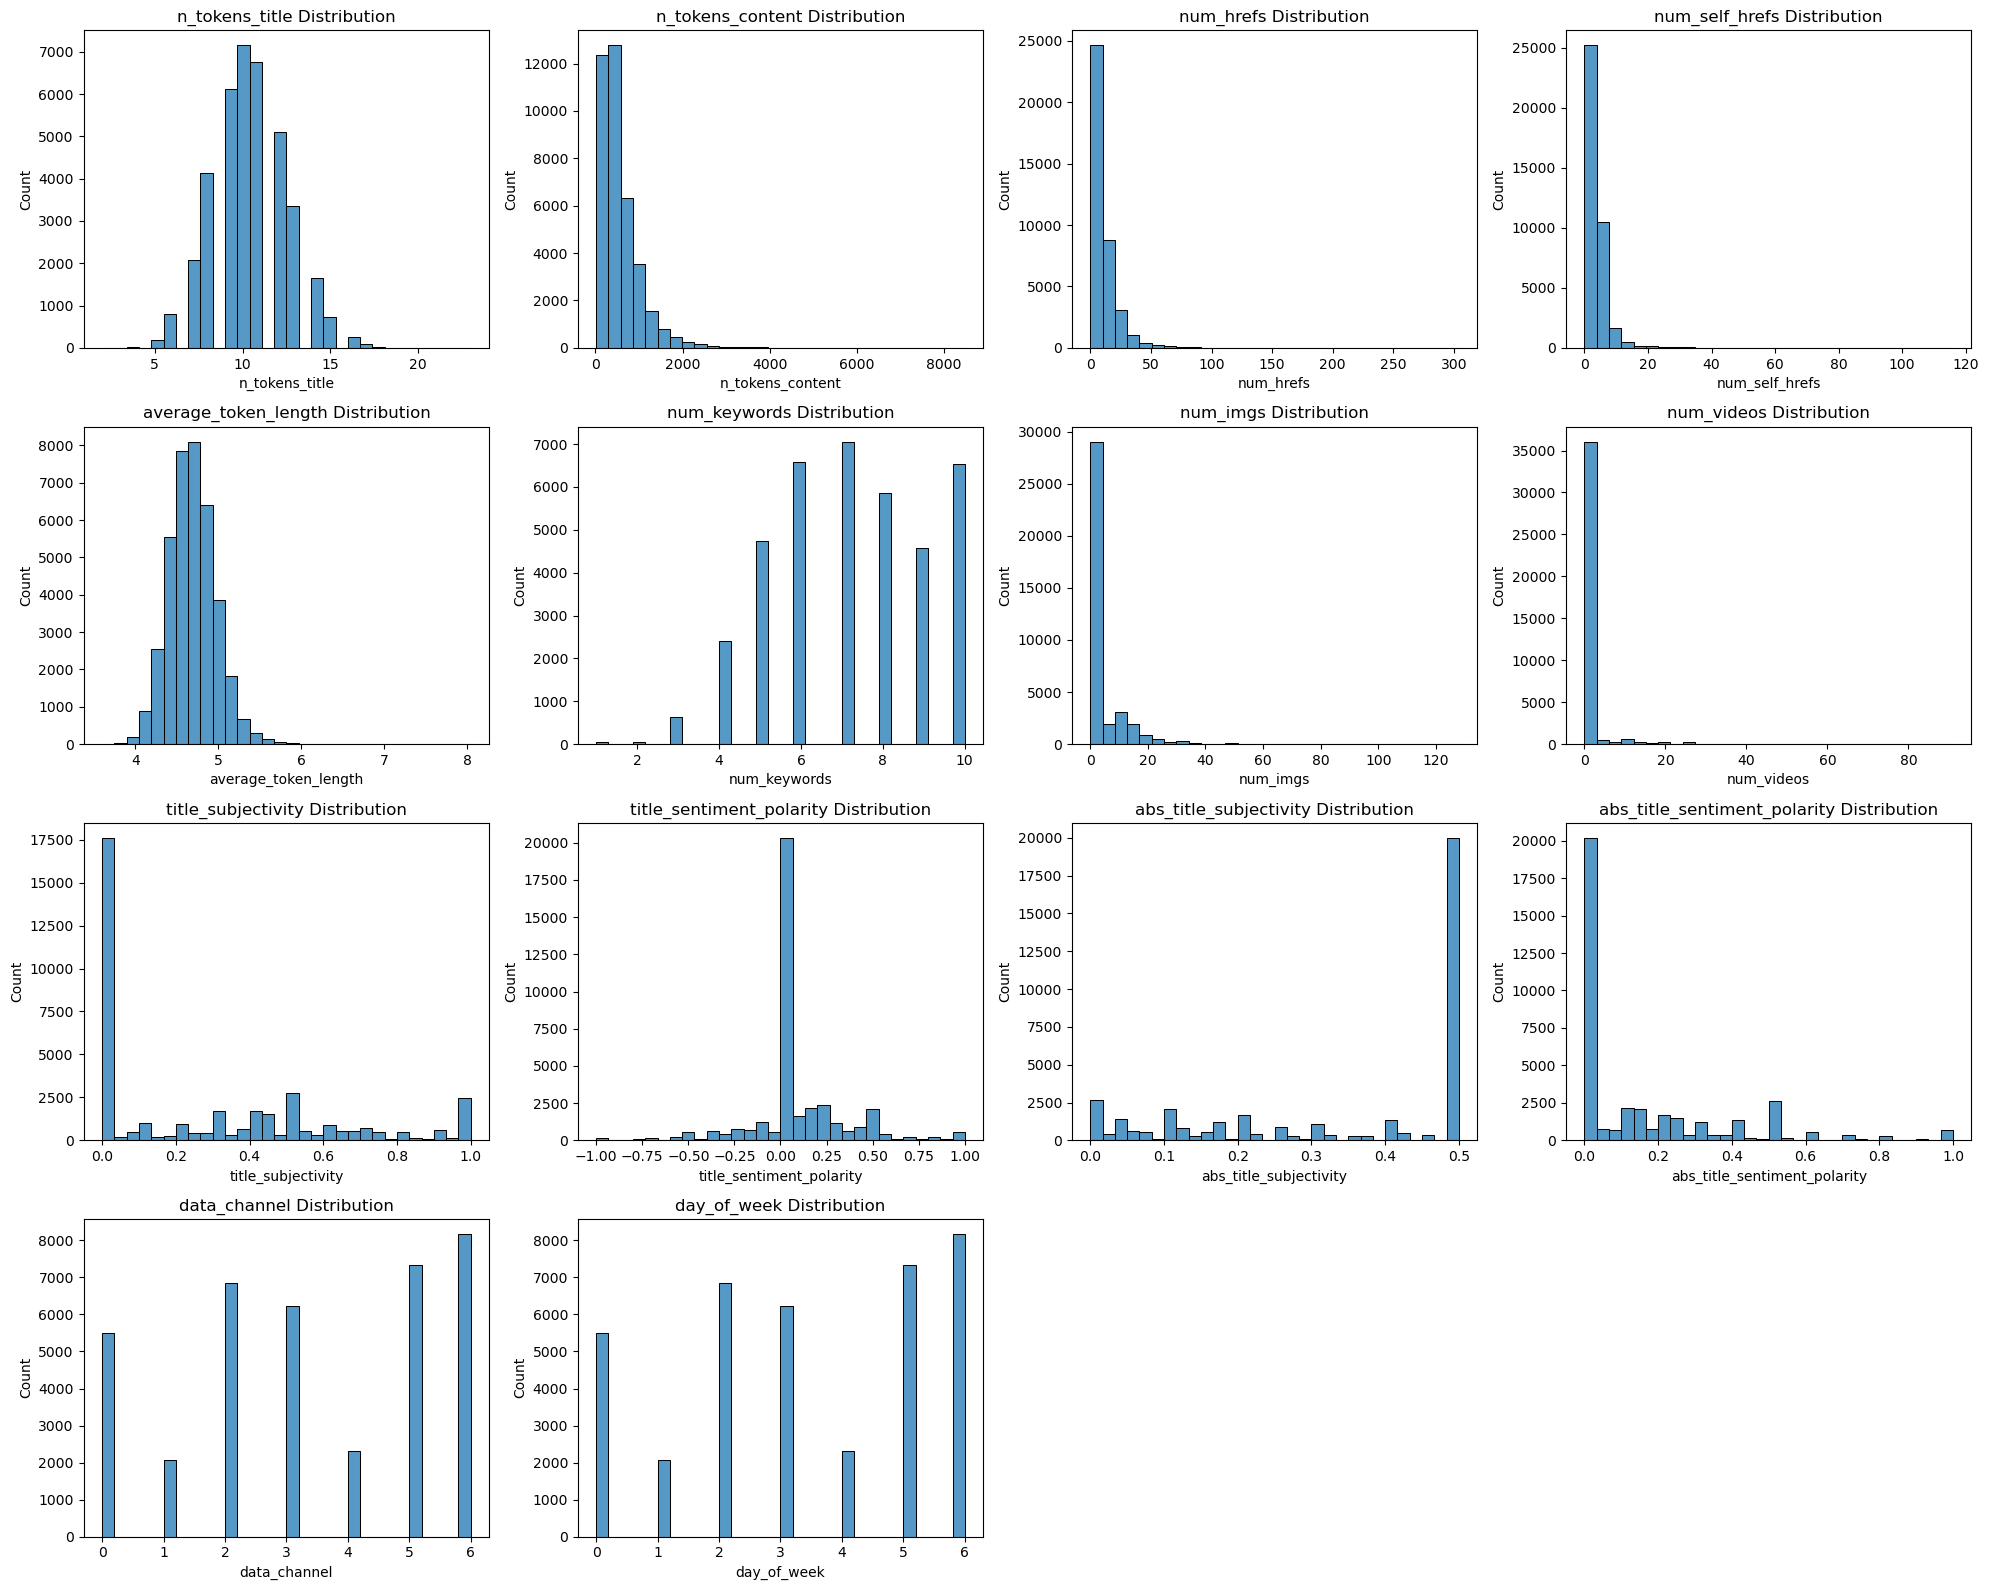

In [12]:
%matplotlib inline

cols = [
    'n_tokens_title', 'n_tokens_content', 'num_hrefs',
    'num_self_hrefs', 'average_token_length', 'num_keywords',
    'num_imgs', 'num_videos', 'title_subjectivity',
    'title_sentiment_polarity', 'abs_title_subjectivity',
    'abs_title_sentiment_polarity', 'data_channel', 'day_of_week'
]

fig, axes = plt.subplots(4, 4, figsize=(20, 16))  # Adjust height based on rows
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.histplot(tmp_df[col], bins=30, ax=ax)
    ax.set_title(f'{col} Distribution')

# Hide unused axes
for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

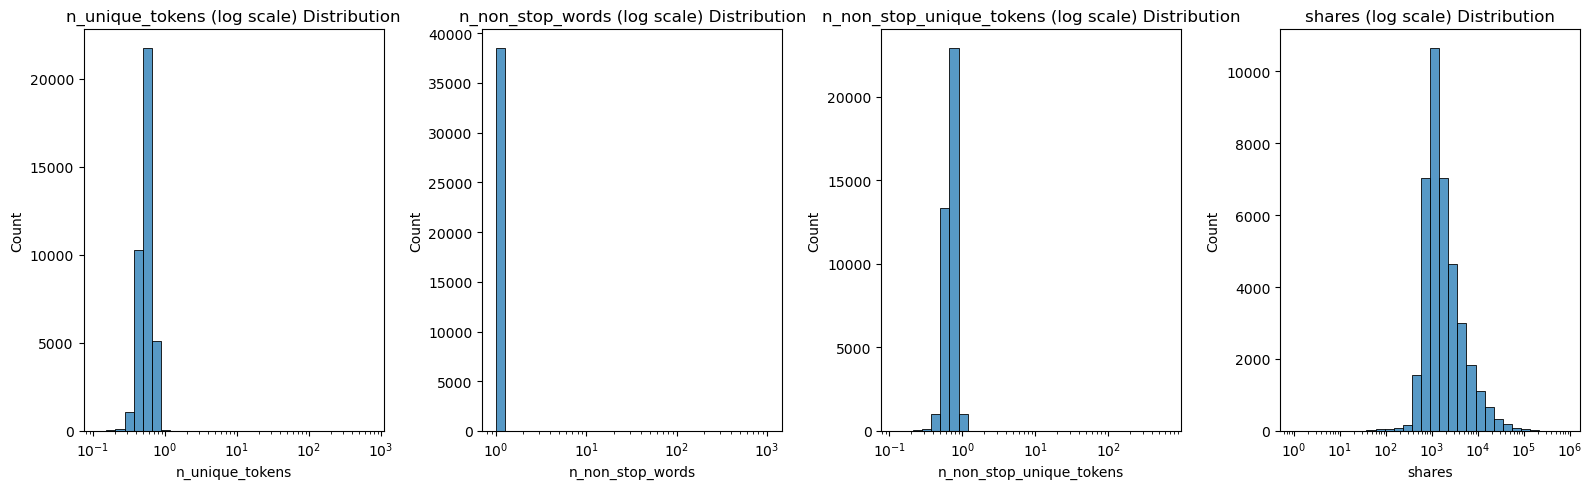

In [13]:
%matplotlib inline

cols = ['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'shares']
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, col in zip(axes, cols):
    if (tmp_df[col] <= 0).any():
        continue
    sns.histplot(tmp_df[col], bins=30, ax=ax, log_scale=True)
    ax.set_title(f'{col} (log scale) Distribution')

plt.tight_layout()
plt.show()

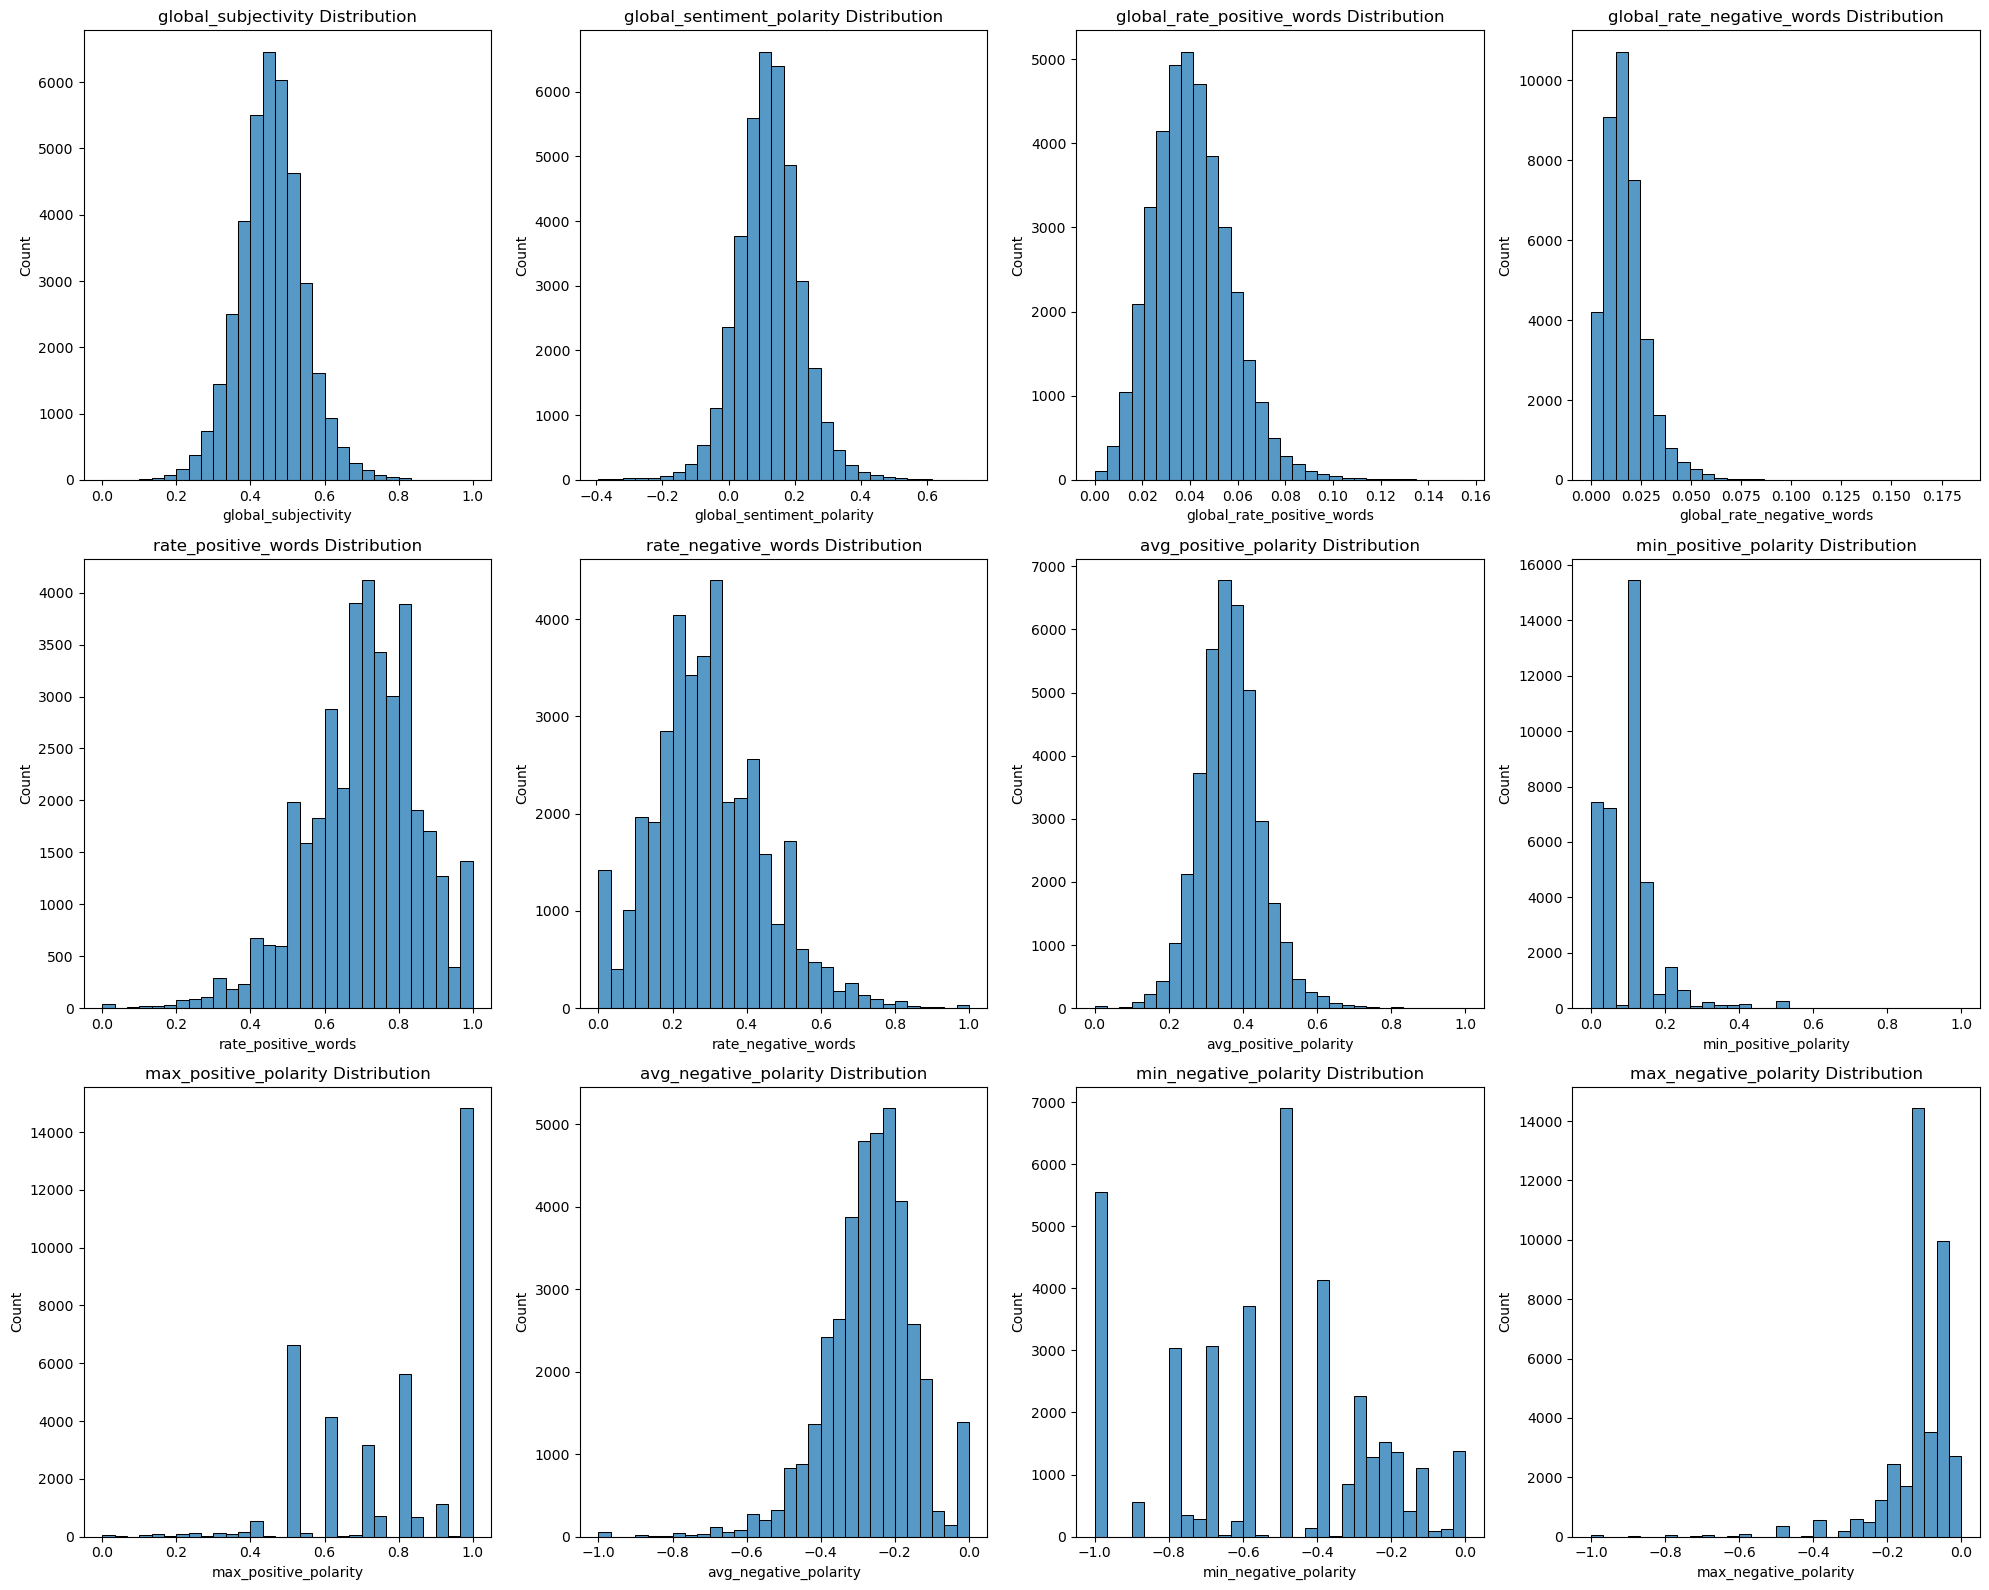

In [14]:
%matplotlib inline

cols = ['global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity']

fig, axes = plt.subplots(3, 4, figsize=(20, 16))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.histplot(df[col], bins=30, ax=ax)
    ax.set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

In [15]:
tmp_df.drop(['num_self_hrefs', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess'], axis='columns', inplace=True, errors='ignore')

### Remove Redundant and Unimportant Features to Reduce Multicollinearity

In [16]:
df.drop(['num_self_hrefs', 'self_reference_min_shares',
         'self_reference_max_shares', 'self_reference_avg_sharess'],
        axis='columns',
        inplace=True,
        errors='ignore')

In [17]:
df.rename(columns={
    'kw_min_min': 'min_share_worst_keyword',
    'kw_avg_min': 'avg_share_worst_keyword',
    'kw_min_max': 'min_share_best_keyword',
    'kw_max_max': 'max_share_best_keyword',
    'kw_avg_max': 'avg_share_best_keyword',
    'kw_min_avg': 'min_share_avg_keyword',
    'kw_max_avg': 'max_share_avg_keyword',
    'kw_avg_avg': 'avg_share_avg_keyword',
    'LDA_00': 'closeness_to_topic_0',
    'LDA_01': 'closeness_to_topic_1',
    'LDA_02': 'closeness_to_topic_2',
    'LDA_03': 'closeness_to_topic_3',
    'LDA_04': 'closeness_to_topic_4',
    'global_subjectivity': 'text_subjectivity',
    'global_sentiment_polarity': 'text_sentiment_polarity',
    'global_rate_positive_words': 'rate_pos_word_in_text',
    'global_rate_negative_words': 'rate_neg_word_in_text',
    'rate_negative_words': 'rate_neg_word_in_polarized_text'
    
}, inplace=True)

In [18]:
df.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'min_share_worst_keyword', 'kw_max_min',
       'avg_share_worst_keyword', 'min_share_best_keyword',
       'max_share_best_keyword', 'avg_share_best_keyword',
       'min_share_avg_keyword', 'max_share_avg_keyword',
       'avg_share_avg_keyword', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend',
       'closeness_to_topic_0', 'closeness_to_topic_1', 'closeness_to_topic_2',
       'closeness_to_topic_3', 'closeness_to_topic_4', 'text_subjectivity',
       'text_sentiment_pola

## Feature Selection

In [19]:
random.seed(42)
np.random.seed(42)

cutoff = df['shares'].quantile(0.5)
df['popular'] = np.where(df['shares'] >= cutoff, 1, 0)

In [20]:
X = df.drop(['shares', 'popular'], axis=1)
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
scaled_matrix = np.hstack((X_train_scaled, y_train.to_numpy().reshape(-1, 1)))
corr_matrix = np.corrcoef(scaled_matrix, rowvar=False)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

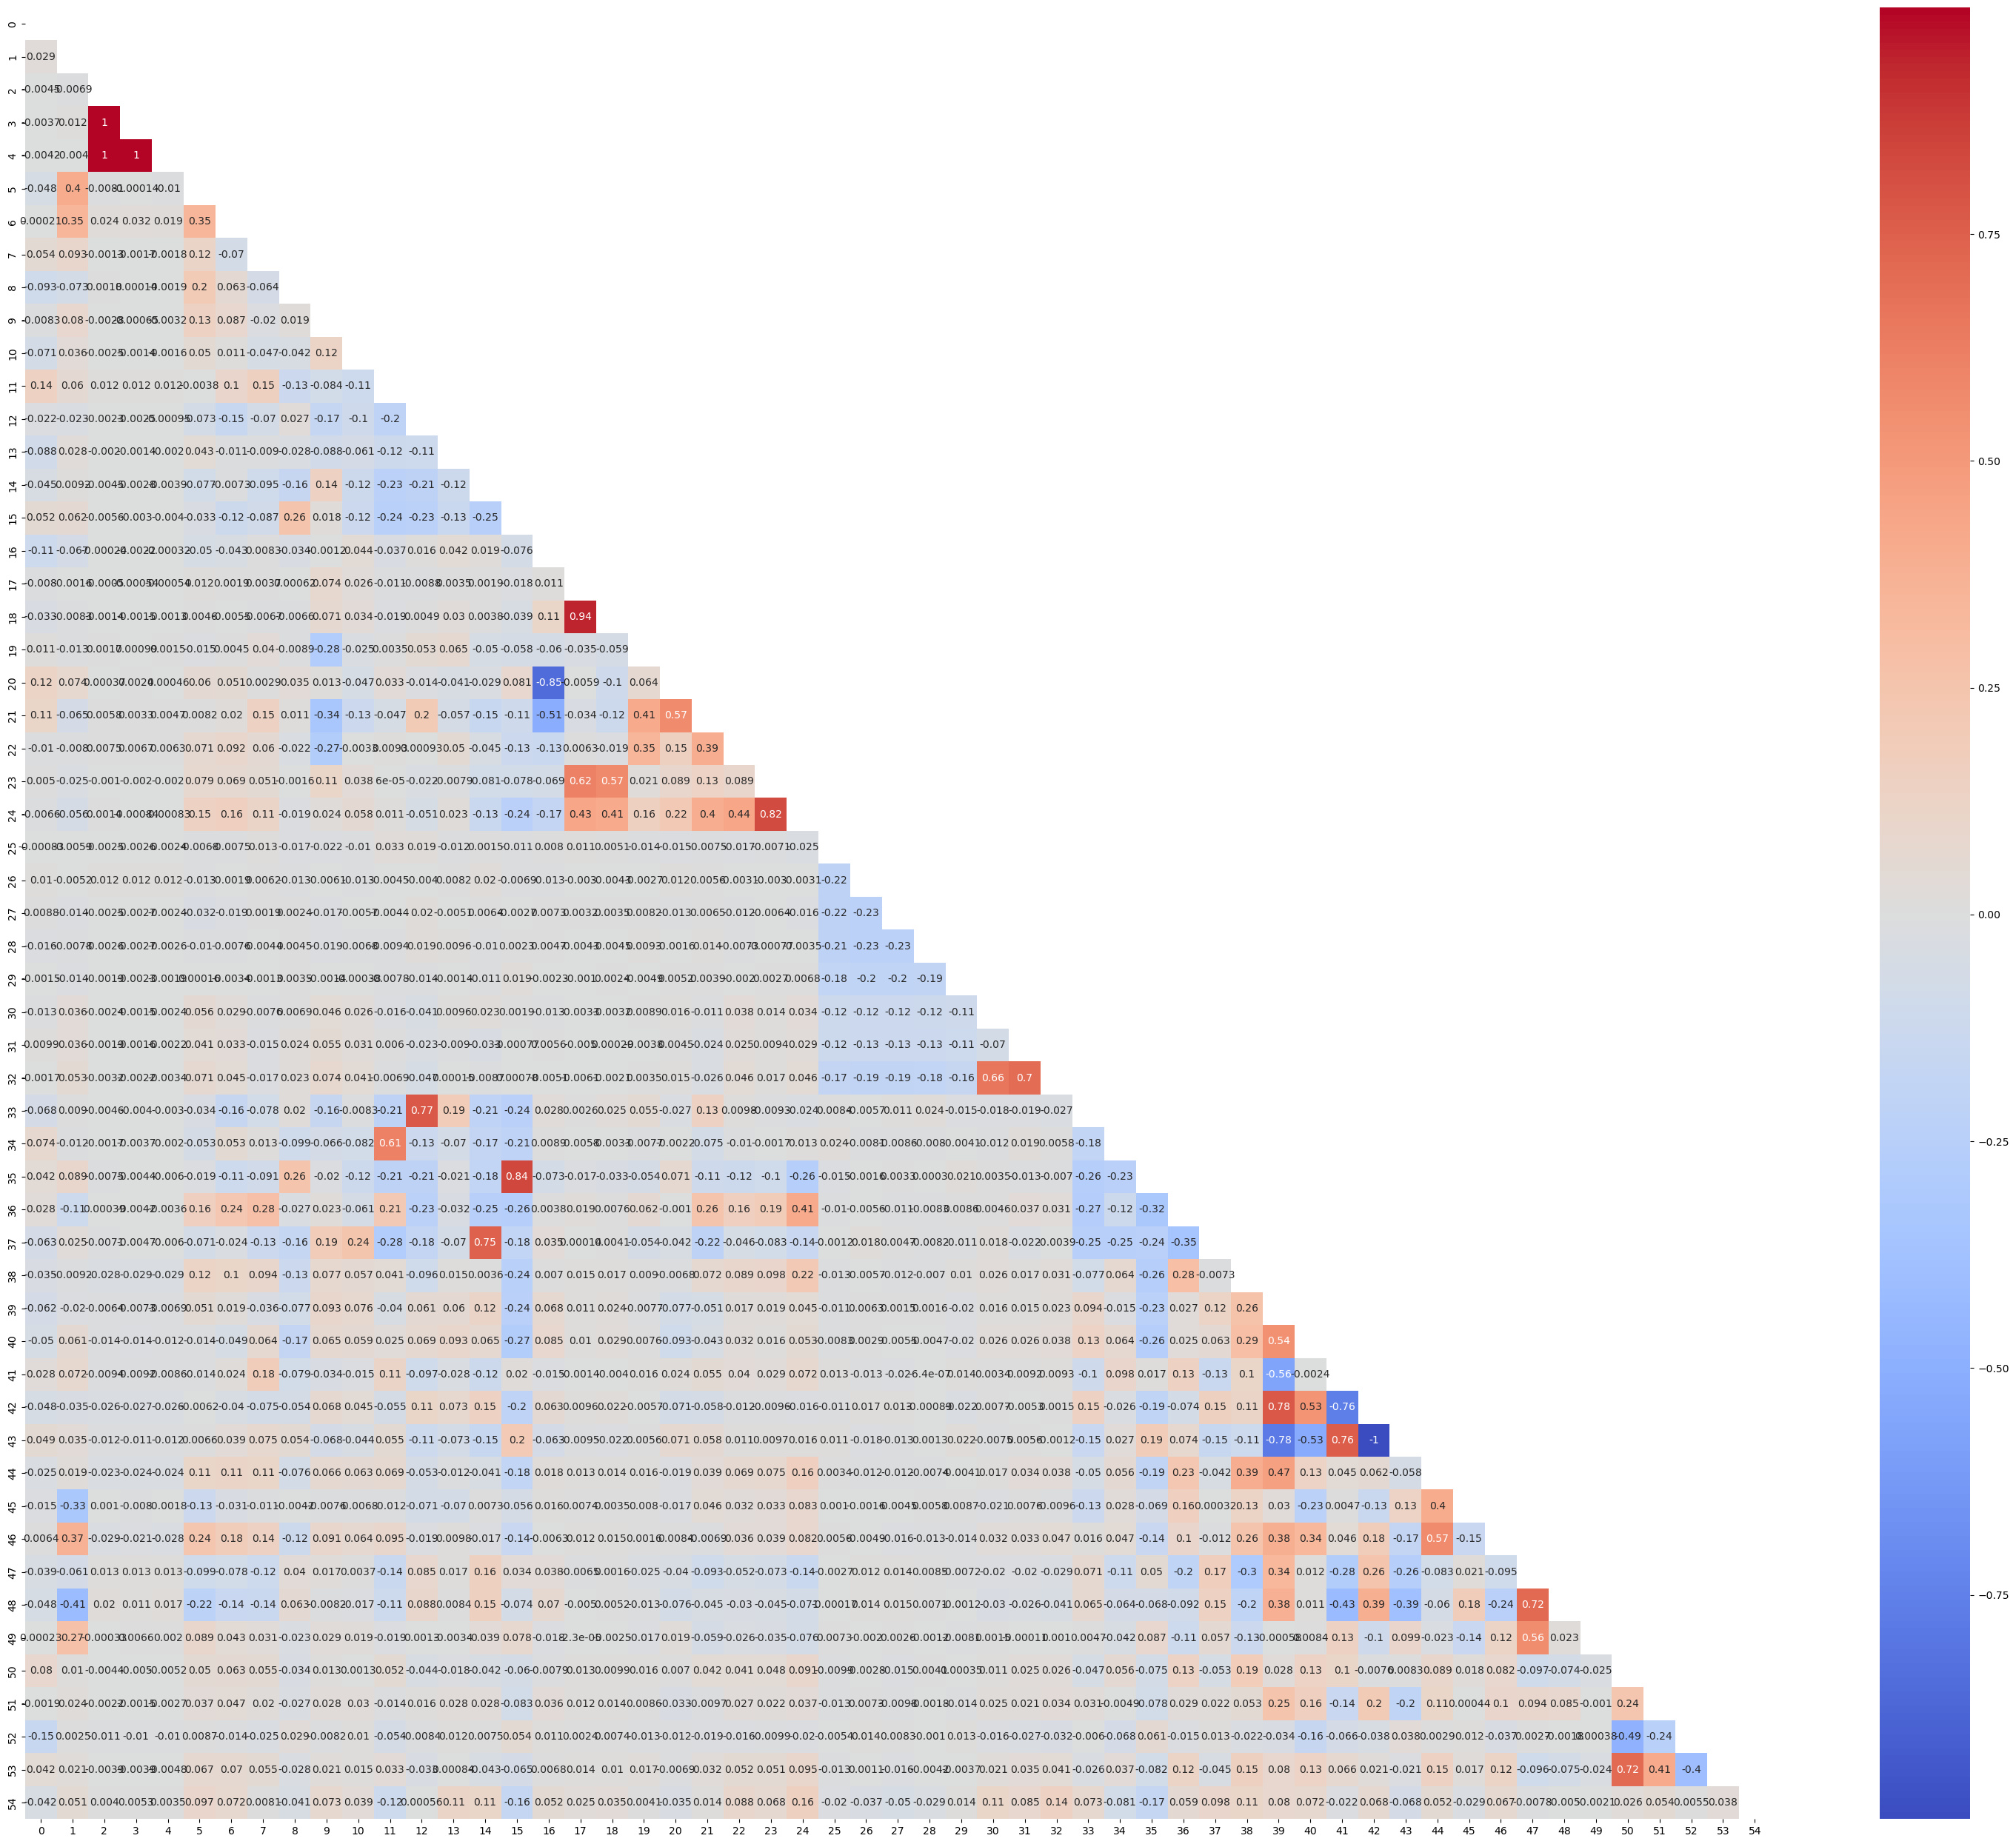

In [23]:
plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix,
            annot=True,
            mask=mask,
            cmap='coolwarm',
            xticklabels=range(corr_matrix.shape[1]),
            yticklabels=range(corr_matrix.shape[0]))
plt.tight_layout()
plt.show()

### Feature Selection Using Fisher Score

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.stats import ttest_ind

def fisher_score(X, y):
    """
    Compute Fisher score for each feature.

    Args:
        X: 2D array of features (n_samples, n_features)
        y: 1D array of binary labels (0=unpopular, 1=popular)
    
    Returns:
        Fisher scores (higher = more discriminative)
    """
    X_popular = X[y == 1]
    X_unpopular = X[y == 0]
    
    # Between-class separation
    mean_popular = np.mean(X_popular, axis=0)
    mean_unpopular = np.mean(X_unpopular, axis=0)
    between_class = (mean_popular - mean_unpopular) ** 2
    
    # Within-class scatter
    var_popular = np.var(X_popular, axis=0, ddof=1)
    var_unpopular = np.var(X_unpopular, axis=0, ddof=1)
    within_class = var_popular + var_unpopular
    
    epsilon = 1e-10 # Handle division by zero
    scores = between_class / (within_class + epsilon)
    
    return scores

# Compute Fisher scores
f_scores = fisher_score(X_train_scaled, y_train)
ranked_features = np.argsort(f_scores)[::-1]  # Descending order

In [25]:
k_values = [10, 20, 30, 40, 50]
best_score = -1
best_k = 0

for k in k_values:
    X_train_selected = X_train_scaled[:, ranked_features[:k]]
    
    # Cross-validation
    model = LogisticRegression(max_iter=1000)
    scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1')
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Best k: {best_k}, Best F1-score: {best_score:.3f}")

Best k: 40, Best F1-score: 0.684


In [26]:
top_k_features = X_train.columns[ranked_features[:best_k]].tolist()
print(f"Top {best_k} features:", top_k_features)

Top 40 features: ['closeness_to_topic_2', 'data_channel_is_world', 'avg_share_avg_keyword', 'is_weekend', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'weekday_is_saturday', 'data_channel_is_tech', 'text_subjectivity', 'closeness_to_topic_4', 'num_hrefs', 'min_share_avg_keyword', 'weekday_is_sunday', 'closeness_to_topic_1', 'text_sentiment_polarity', 'closeness_to_topic_0', 'num_keywords', 'num_imgs', 'rate_pos_word_in_text', 'rate_neg_word_in_polarized_text', 'rate_positive_words', 'max_share_avg_keyword', 'max_positive_polarity', 'closeness_to_topic_3', 'title_sentiment_polarity', 'min_share_worst_keyword', 'avg_positive_polarity', 'n_tokens_content', 'weekday_is_wednesday', 'n_tokens_title', 'average_token_length', 'data_channel_is_lifestyle', 'abs_title_sentiment_polarity', 'weekday_is_tuesday', 'avg_share_worst_keyword', 'max_share_best_keyword', 'min_positive_polarity', 'weekday_is_thursday', 'title_subjectivity', 'kw_max_min']


In [27]:
X_train_fs = X_train_scaled[:, ranked_features[:best_k]]
X_test_fs = X_test_scaled[:, ranked_features[:best_k]]
print(f"Filtered shape: {X_train_fs.shape}")

Filtered shape: (30770, 40)


### Feature Selection Using Genetics Algorithm (DEAP)

In [28]:
NUM_FEATURES = X_train.shape[1]
ALPHA = 0.7
POPULATION_SIZE = 50

# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=NUM_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [29]:
# Fitness Function
def evaluate(individual):
    """
    Evaluate the fitness of a feature subset for feature selection

    Args:
        individual (array-like): A binary vector, where True indicates feature is selected.

    Returns:
        tuple: a single element tuple containing the fitness score.
    """
    selected = np.where(individual)[0]
    if len(selected) == 0:
        return (0.0,)
    
    # 1. Relevance: Use SCALED data for ANOVA F-test
    f_scores, _ = f_classif(X_train_scaled[:, selected], y_train)  # Use scaled data
    R = np.mean(f_scores)
    
    # 2. Redundancy: Use ORIGINAL data for correlation (scale-invariant)
    corr_matrix = X_train.iloc[:, selected].corr().abs().values  # Original data
    np.fill_diagonal(corr_matrix, 0)
    r = np.sum(corr_matrix) / (len(selected) * (len(selected) - 1)) if len(selected) > 1 else 0.0
    
    fitness = ALPHA * R - (1 - ALPHA) * r
    return (fitness,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [30]:
# Execute Genetic Algorithm
population = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

population, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=20,
    stats=stats, halloffame=hof, verbose=True
)

gen	nevals	avg    	max    
0  	50    	111.382	170.432
1  	39    	127.365	169.889
2  	42    	142.343	171.483
3  	33    	154.812	173.269
4  	41    	162.799	184.065
5  	38    	171.967	207.178
6  	39    	181.212	236.987
7  	34    	193.193	236.987
8  	40    	204.113	236.987
9  	35    	210.32 	243.94 
10 	40    	219.237	249.102
11 	37    	226.575	255.974
12 	34    	233.705	255.974
13 	33    	242.172	260.533
14 	45    	241.325	278.696
15 	44    	249.893	283.263
16 	32    	260.979	285.514
17 	39    	263.666	292.796
18 	40    	271.751	302.757
19 	38    	281.815	308.954
20 	37    	284.211	308.954


In [31]:
# Get selected features from original col name
selected_features = X_train.columns[np.where(hof[0])[0]].tolist()
print("Selected Features:", selected_features)

Selected Features: ['num_hrefs', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'avg_share_worst_keyword', 'max_share_avg_keyword', 'avg_share_avg_keyword', 'is_weekend', 'closeness_to_topic_0', 'closeness_to_topic_2', 'text_subjectivity']


In [32]:
selected_indices = np.where(hof[0])[0]

X_train_ga = X_train_scaled[:, selected_indices]
X_test_ga = X_test_scaled[:, selected_indices]
print(f"Filtered shape: {X_train_ga.shape}")

Filtered shape: (30770, 11)


In [33]:
def print_model_stats(model, X_train, X_test, y_train, y_test):
    """
    Print the model training and test statistics

    Args:
        model: the trained model to perform predictions
        X_train (ndarray): training feature matrix
        X_test (ndarray): test feature matrix
        y_train (list-like): labels for training set
        y_test (list-like): labels for test set
    """
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    print("-"*25 + "Train Stats" + "-"*25)
    print(classification_report(y_train_pred, y_train))
    print(f"ROC-AUC: {roc_auc_score(y_train, y_train_prob):.3f}")
    print("-"*25 + "Test Stats" + "-"*25)
    print(classification_report(y_test_pred, y_test))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_test_prob):.3f}")

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate the model and return the data in a dictionary

    Args:
        model: the trained model to perform predictions
        X_train (ndarray): training feature matrix
        X_test (ndarray): test feature matrix
        y_train (list-like): labels for training set
        y_test (list-like): labels for test set
        model_name (str): name of the model

    Return:
        Dict: dictionary containing the model metrics
    """
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    metrics = {
        'Model': model_name,
        'Train_Accuracy': train_report['accuracy'],
        'Train_Precision': train_report['weighted avg']['precision'],
        'Train_Recall': train_report['weighted avg']['recall'],
        'Train_F1': train_report['weighted avg']['f1-score'],
        'Train_ROC-AUC': roc_auc_score(y_train, y_train_prob),
        'Test_Accuracy': test_report['accuracy'],
        'Test_Precision': test_report['weighted avg']['precision'],
        'Test_Recall': test_report['weighted avg']['recall'],
        'Test_F1': test_report['weighted avg']['f1-score'],
        'Test_ROC-AUC': roc_auc_score(y_test, y_test_prob)
    }
    return metrics

results_list = []

## Building Random Forest (Fisher Score)

### First Pass with RandomizedSearchCV

In [34]:
params = {
    'max_depth': list(np.arange(10, 100, 10)) + [None],
    'n_estimators': np.arange(10, 250, 50),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': np.arange(2, 10, step=2),
    'max_features': ['sqrt', 'log2', 0.5],
    'min_impurity_decrease': [1e-4, 1e-3, 0.01, 0.1, 0.0],
}
rf_model = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, bootstrap=True),
    params,
    n_iter=50,
    scoring='accuracy',
    cv=5
)
rf_model.fit(X_train_fs, y_train)

print('Best hyperparameter: '+ str(rf_model.best_params_))
print('Best score: '+ str(rf_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda

Best hyperparameter: {'n_estimators': np.int64(160), 'min_samples_split': np.int64(6), 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_features': 'log2', 'max_depth': np.int64(30)}
Best score: 0.6677608059798504


In [35]:
best_rf_model_fs = rf_model.best_estimator_
print_model_stats(best_rf_model_fs, X_train_fs, X_test_fs, y_train, y_test)

-------------------------Train Stats-------------------------
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     13212
           1       0.86      0.80      0.83     17558

    accuracy                           0.81     30770
   macro avg       0.81      0.81      0.81     30770
weighted avg       0.81      0.81      0.81     30770

ROC-AUC: 0.897
-------------------------Test Stats-------------------------
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      3253
           1       0.73      0.67      0.70      4440

    accuracy                           0.66      7693
   macro avg       0.66      0.66      0.66      7693
weighted avg       0.67      0.66      0.67      7693

ROC-AUC: 0.723


### Second Pass with Bayesian Optimization

In [36]:
params = {
    'n_estimators': Integer(140, 180),
    'min_samples_split': Integer(4, 8),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Categorical(['sqrt', 'log2', 0.3, 0.4]),
    'max_depth': Integer(20, 60),
    'min_impurity_decrease': [1e-4, 1e-3, 0.01, 0.1, 0.0],
}
rf_model = BayesSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, bootstrap=True),
    params,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
)

rf_model.fit(X_train_fs, y_train)

print('Best hyperparameter: '+ str(rf_model.best_params_))
print('Best score: '+ str(rf_model.best_score_))

Best hyperparameter: OrderedDict([('max_depth', 60), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('min_samples_leaf', 4), ('min_samples_split', 4), ('n_estimators', 180)])
Best score: 0.668118297042574


In [37]:
best_rf_model_fs = rf_model.best_estimator_
fs_metrics = evaluate_model(best_rf_model_fs, X_train_fs, X_test_fs, y_train,
                            y_test, 'Random Forest (Fisher Score)')
results_list.append(fs_metrics)

## Building Random Forest (Genetics Algorithm)

### First Pass with RandomizedSearchCV

In [38]:
params = {
    'max_depth': list(np.arange(10, 100, 10)) + [None],
    'n_estimators': np.arange(10, 250, 50),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': np.arange(2, 10, step=2),
    'max_features': ['sqrt', 'log2', 0.5],
    'min_impurity_decrease': [1e-4, 1e-3, 0.01, 0.1, 0.0],
}
rf_model = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, bootstrap=True),
    params,
    n_iter=50,
    scoring='accuracy',
    cv=5
)
rf_model.fit(X_train_ga, y_train)

print('Best hyperparameter: '+ str(rf_model.best_params_))
print('Best score: '+ str(rf_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ulricye/miniconda

Best hyperparameter: {'n_estimators': np.int64(160), 'min_samples_split': np.int64(8), 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0001, 'max_features': 'log2', 'max_depth': np.int64(80)}
Best score: 0.6516087097822554


In [39]:
best_rf_model_ga = rf_model.best_estimator_
print_model_stats(best_rf_model_ga, X_train_ga, X_test_ga, y_train, y_test)

-------------------------Train Stats-------------------------
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     13308
           1       0.78      0.73      0.75     17462

    accuracy                           0.73     30770
   macro avg       0.73      0.73      0.73     30770
weighted avg       0.73      0.73      0.73     30770

ROC-AUC: 0.807
-------------------------Test Stats-------------------------
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      3346
           1       0.70      0.66      0.68      4347

    accuracy                           0.65      7693
   macro avg       0.64      0.65      0.64      7693
weighted avg       0.65      0.65      0.65      7693

ROC-AUC: 0.706


### Second Pass with Bayesian Optimization

In [40]:
params = {
    'n_estimators': Integer(140, 180),
    'min_samples_split': Integer(6, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2', 0.3, 0.4]),
    'max_depth': Integer(60, 100),
    'min_impurity_decrease': [1e-4, 1e-3, 0.01, 0.1, 0.0],
}
rf_model = BayesSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, bootstrap=True),
    params,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
)

rf_model.fit(X_train_ga, y_train)

print('Best hyperparameter: '+ str(rf_model.best_params_))
print('Best score: '+ str(rf_model.best_score_))

Best hyperparameter: OrderedDict([('max_depth', 95), ('max_features', 'log2'), ('min_impurity_decrease', 0.0001), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 150)])
Best score: 0.6532336691582711


In [41]:
best_rf_model_ga = rf_model.best_estimator_
ga_metrics = evaluate_model(best_rf_model_ga, X_train_ga, X_test_ga, y_train,
                            y_test, 'Random Forest (Genetics)')
results_list.append(ga_metrics)

## Building XGBoost Model (Fisher Score)

### First Pass with RandomizedSearchCV

In [42]:
from xgboost import XGBClassifier

In [43]:
xgb_params = {
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': np.arange(10, 150, 50),
    'max_depth': list(np.arange(10, 100, 10)) + [None],
    'learning_rate': [0.001, 0.005, 0.01, 0.1],
    'growth_policy': ['depthwise', 'lossguide'],
    'gamma': [0, 0.1, 0.2],
}

In [44]:
xgb_model = RandomizedSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42, objective='binary:logistic'),
    xgb_params,
    n_iter=50,
    scoring='accuracy',
    cv=5
)
xgb_model.fit(X_train_fs, y_train)

print('Best hyperparameter: '+ str(xgb_model.best_params_))
print('Best score: '+ str(xgb_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best hyperparameter: {'subsample': 0.8, 'n_estimators': np.int64(110), 'max_depth': np.int64(10), 'learning_rate': 0.01, 'growth_policy': 'depthwise', 'gamma': 0.1}
Best score: 0.6653558661033474


In [45]:
best_xgb_model = xgb_model.best_estimator_
print_model_stats(best_xgb_model, X_train_fs, X_test_fs, y_train, y_test)

-------------------------Train Stats-------------------------
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     13175
           1       0.83      0.78      0.81     17595

    accuracy                           0.78     30770
   macro avg       0.78      0.79      0.78     30770
weighted avg       0.79      0.78      0.79     30770

ROC-AUC: 0.872
-------------------------Test Stats-------------------------
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      3167
           1       0.73      0.66      0.69      4526

    accuracy                           0.66      7693
   macro avg       0.65      0.66      0.65      7693
weighted avg       0.67      0.66      0.66      7693

ROC-AUC: 0.722


### Second Pass with Bayesian Optimization

In [46]:
# log transformed label
xgb_params = {
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': np.arange(80, 130, 10),
    'max_depth': list(np.arange(1, 20, 5)) + [None],
    'learning_rate': [0.001, 0.005, 0.01, 0.1],
    'growth_policy': ['depthwise', 'lossguide'],
    'gamma': [0, 0.1, 0.2],
}
xgb_model = BayesSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42, objective='binary:logistic'),
    xgb_params,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)
xgb_model.fit(X_train_fs, y_train)

print('Best hyperparameter: '+ str(xgb_model.best_params_))
print('Best score: '+ str(xgb_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best hyperparameter: OrderedDict([('gamma', 0), ('growth_policy', 'depthwise'), ('learning_rate', 0.1), ('max_depth', 6), ('n_estimators', 90), ('subsample', 0.8)])
Best score: 0.6675658108547287


In [47]:
best_xgb_model_fs = xgb_model.best_estimator_
fs_metrics = evaluate_model(best_xgb_model_fs, X_train_fs, X_test_fs, y_train,
                            y_test, 'XGB (Fisher Score)')
results_list.append(fs_metrics)

## Building XGBoost Model (Genetic Algorithm)

### First Pass with RandomizedSearchCV

In [48]:
xgb_params = {
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': np.arange(10, 150, 50),
    'max_depth': list(np.arange(10, 100, 10)) + [None],
    'learning_rate': [0.001, 0.005, 0.01, 0.1],
    'growth_policy': ['depthwise', 'lossguide'],
    'gamma': [0, 0.1, 0.2],
}

xgb_model = RandomizedSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42, objective='binary:logistic'),
    xgb_params,
    n_iter=50,
    scoring='accuracy',
    cv=5
)
xgb_model.fit(X_train_ga, y_train)

print('Best hyperparameter: '+ str(xgb_model.best_params_))
print('Best score: '+ str(xgb_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best hyperparameter: {'subsample': 0.8, 'n_estimators': np.int64(60), 'max_depth': None, 'learning_rate': 0.1, 'growth_policy': 'lossguide', 'gamma': 0.1}
Best score: 0.6503412414689633


/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [49]:
best_xgb_model = xgb_model.best_estimator_
print_model_stats(best_xgb_model, X_train_ga, X_test_ga, y_train, y_test)

-------------------------Train Stats-------------------------
              precision    recall  f1-score   support

           0       0.65      0.68      0.66     13715
           1       0.73      0.70      0.72     17055

    accuracy                           0.69     30770
   macro avg       0.69      0.69      0.69     30770
weighted avg       0.69      0.69      0.69     30770

ROC-AUC: 0.766
-------------------------Test Stats-------------------------
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      3490
           1       0.68      0.66      0.67      4203

    accuracy                           0.65      7693
   macro avg       0.65      0.65      0.65      7693
weighted avg       0.65      0.65      0.65      7693

ROC-AUC: 0.705


### Second Pass with Bayesian Optimization

In [50]:
# log transformed label
xgb_params = {
    'subsample': [ 0.4, 0.6, 0.8],
    'n_estimators': np.arange(1, 20, 5),
    'max_depth': list(np.arange(10, 100, 10)) + [None],
    'learning_rate': [0.001, 0.005, 0.01, 0.1],
    'growth_policy': ['depthwise', 'lossguide'],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
}
xgb_model = BayesSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42, objective='binary:logistic'),
    xgb_params,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)
xgb_model.fit(X_train_ga, y_train)

print('Best hyperparameter: '+ str(xgb_model.best_params_))
print('Best score: '+ str(xgb_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best hyperparameter: OrderedDict([('gamma', 0.1), ('growth_policy', 'depthwise'), ('learning_rate', 0.1), ('max_depth', None), ('n_estimators', 16), ('subsample', 0.8)])
Best score: 0.6485862853428663


/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "growth_policy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [51]:
best_xgb_model_ga = xgb_model.best_estimator_
ga_metrics = evaluate_model(best_xgb_model_ga, X_train_ga, X_test_ga, y_train,
                            y_test, 'XGB (Genetic Algorithm)')
results_list.append(ga_metrics)

## Building Neural Network (Fisher Score)

### RandomizedSearchCV

In [52]:
nn_params = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh', 'logistic'], 
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_iter': [100, 150, 200]
}

mlp_model = RandomizedSearchCV(
    MLPClassifier(early_stopping=True, random_state=42),
    nn_params,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
mlp_model.fit(X_train_fs, y_train)

print('Best hyperparameter: '+ str(mlp_model.best_params_))
print('Best score: '+ str(mlp_model.best_score_))

Best hyperparameter: {'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (64, 32), 'batch_size': 32, 'alpha': 0.0001, 'activation': 'tanh'}
Best score: 0.6563535911602211


In [53]:
best_mlp_model_fs = mlp_model.best_estimator_
fs_metrics = evaluate_model(best_mlp_model_fs, X_train_fs, X_test_fs, y_train,
                            y_test, 'MLP (Fisher Score)')
results_list.append(fs_metrics)

## Building Neural Network (Genetic Algorithm)

### RandomizedSearchCV

In [54]:
nn_params = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh', 'logistic'], 
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_iter': [100, 150, 200]
}

mlp_model = RandomizedSearchCV(
    MLPClassifier(early_stopping=True, random_state=42),
    nn_params,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
mlp_model.fit(X_train_ga, y_train)

print('Best hyperparameter: '+ str(mlp_model.best_params_))
print('Best score: '+ str(mlp_model.best_score_))

/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ulricye/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best hyperparameter: {'max_iter': 150, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (64, 32), 'batch_size': 64, 'alpha': 0.0001, 'activation': 'relu'}
Best score: 0.6440038999025025


In [55]:
best_mlp_model_ga = mlp_model.best_estimator_
ga_metrics = evaluate_model(best_mlp_model_ga, X_train_ga, X_test_ga, y_train,
                            y_test, 'MLP (Genetic Algorithm)')
results_list.append(ga_metrics)

## Feature Importance

### Random Forest

In [56]:
rf_importances = best_rf_model_fs.feature_importances_
rf_sorted_indices = np.argsort(rf_importances)[::-1]
sorted_importances = rf_importances[rf_sorted_indices]
sorted_features = [top_k_features[i] for i in rf_sorted_indices]

importance_df = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importances
})
print("Random Forest with Fisher Score Dataset")
print(importance_df)

Random Forest with Fisher Score Dataset
                            Feature  Importance
0             avg_share_avg_keyword    0.064831
1             max_share_avg_keyword    0.057882
2              closeness_to_topic_2    0.049173
3                  n_tokens_content    0.042811
4              closeness_to_topic_4    0.041350
5              closeness_to_topic_1    0.041086
6              closeness_to_topic_0    0.040196
7                 text_subjectivity    0.040049
8           avg_share_worst_keyword    0.039940
9              average_token_length    0.038687
10            rate_pos_word_in_text    0.038531
11          text_sentiment_polarity    0.038202
12            min_share_avg_keyword    0.037315
13             closeness_to_topic_3    0.036031
14            avg_positive_polarity    0.035408
15                       kw_max_min    0.034440
16                        num_hrefs    0.030328
17  rate_neg_word_in_polarized_text    0.029837
18              rate_positive_words    0.029626


In [57]:
rf_importances = best_rf_model_ga.feature_importances_
rf_sorted_indices = np.argsort(rf_importances)[::-1]
sorted_importances = rf_importances[rf_sorted_indices]
sorted_features = [selected_features[i] for i in rf_sorted_indices]

importance_df = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importances
})
print("Random Forest with Genetic Algorithm Dataset")
print(importance_df)

Random Forest with Genetic Algorithm Dataset
                    Feature  Importance
0     avg_share_avg_keyword    0.180685
1     max_share_avg_keyword    0.144087
2      closeness_to_topic_2    0.113225
3      closeness_to_topic_0    0.104268
4   avg_share_worst_keyword    0.099246
5         text_subjectivity    0.082807
6                 num_hrefs    0.069647
7                is_weekend    0.069427
8      data_channel_is_tech    0.063583
9    data_channel_is_socmed    0.037821
10    data_channel_is_world    0.035203


### XGBoost

XGBoost Feature Importance (Fisher Score Dataset)


/var/folders/9y/bmtqz8vs4qbf6x3pzrn6mjp40000gn/T/ipykernel_89277/953014214.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_df, plot_type="bar")


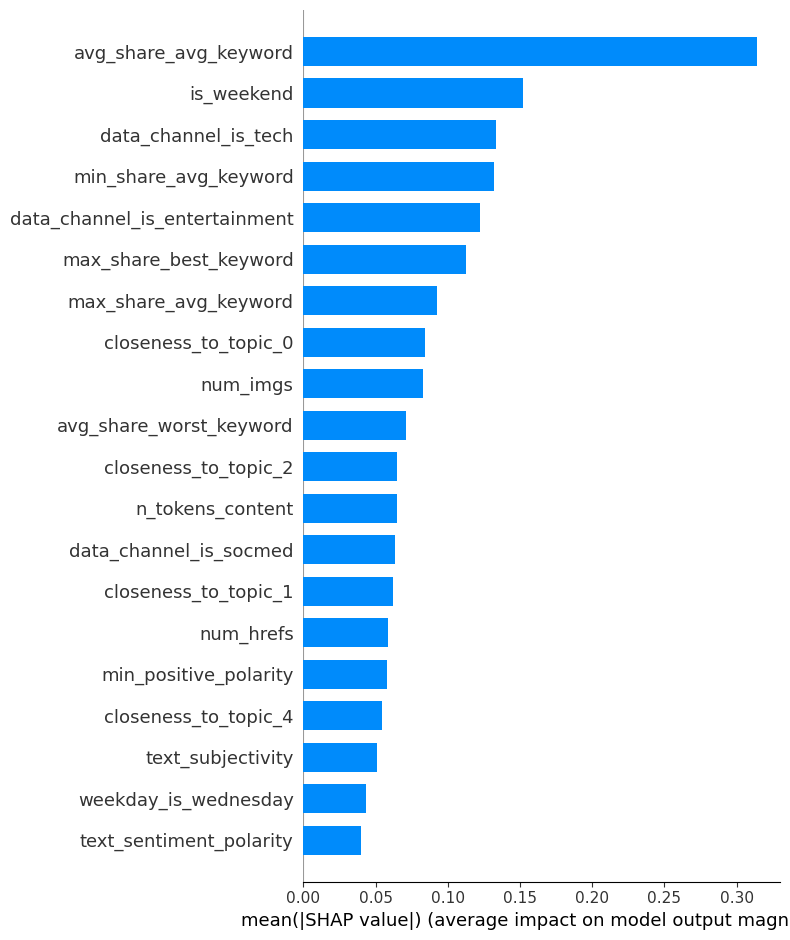

In [58]:
explainer = shap.TreeExplainer(best_xgb_model_fs)
shap_values = explainer.shap_values(X_test_fs)

shap_df = pd.DataFrame(X_test_fs, columns=top_k_features)

print("XGBoost Feature Importance (Fisher Score Dataset)")
shap.summary_plot(shap_values, shap_df, plot_type="bar")
shap.force_plot(explainer.expected_value, shap_values[0,:], shap_df.iloc[0,:])

XGBoost Feature Importance (Genetic Algorithm Dataset)


/var/folders/9y/bmtqz8vs4qbf6x3pzrn6mjp40000gn/T/ipykernel_89277/2216807536.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_df, plot_type="bar")


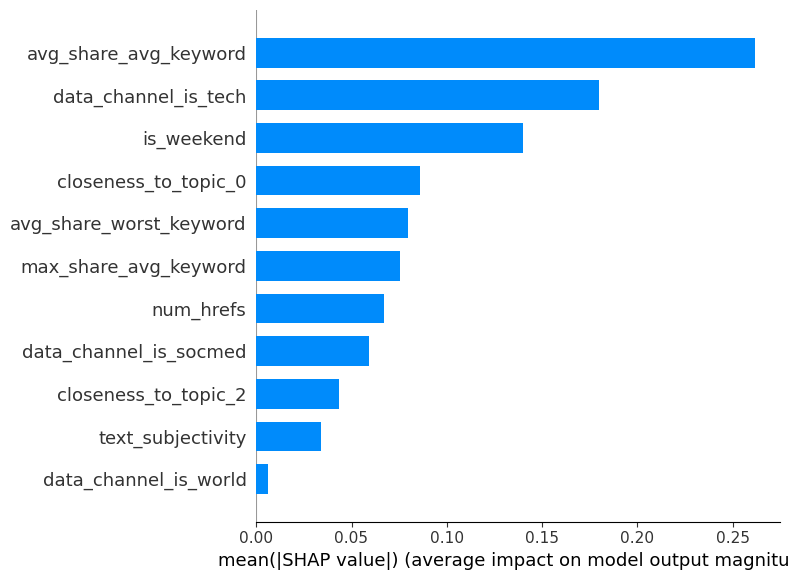

In [59]:
explainer = shap.TreeExplainer(best_xgb_model_ga)
shap_values = explainer.shap_values(X_test_ga)

shap_df = pd.DataFrame(X_test_ga, columns=selected_features)

print("XGBoost Feature Importance (Genetic Algorithm Dataset)")
shap.summary_plot(shap_values, shap_df, plot_type="bar")
shap.force_plot(explainer.expected_value, shap_values[0,:], shap_df.iloc[0,:])

### Neural Network

In [60]:
perm_imp = permutation_importance(best_mlp_model_fs, X_test_fs, y_test, n_repeats=10, random_state=42)
importance = pd.DataFrame({
    "Feature": top_k_features,
    "Importance": perm_imp.importances_mean,
    "std": perm_imp.importances_std
}).sort_values("Importance", ascending=False)
print(importance)

                            Feature  Importance       std
4     data_channel_is_entertainment    0.015287  0.002492
2             avg_share_avg_keyword    0.013714  0.002249
11            min_share_avg_keyword    0.012570  0.003012
7              data_channel_is_tech    0.011855  0.002040
0              closeness_to_topic_2    0.011023  0.001146
5            data_channel_is_socmed    0.009463  0.001151
3                        is_weekend    0.008306  0.001610
16                     num_keywords    0.007136  0.002687
17                         num_imgs    0.004186  0.001618
8                 text_subjectivity    0.003614  0.001383
15             closeness_to_topic_0    0.002600  0.002059
12                weekday_is_sunday    0.002392  0.001366
35           max_share_best_keyword    0.002158  0.001209
1             data_channel_is_world    0.001911  0.001461
25          min_share_worst_keyword    0.001885  0.001469
33               weekday_is_tuesday    0.001677  0.001270
13            

In [61]:
perm_imp = permutation_importance(best_mlp_model_ga, X_test_ga, y_test, n_repeats=10, random_state=42)
importance = pd.DataFrame({
    "Feature": selected_features,
    "Importance": perm_imp.importances_mean,
    "std": perm_imp.importances_std
}).sort_values("Importance", ascending=False)
print(importance)

                    Feature  Importance       std
6     avg_share_avg_keyword    0.043949  0.003952
2      data_channel_is_tech    0.029780  0.003257
7                is_weekend    0.021188  0.002627
1    data_channel_is_socmed    0.016639  0.001804
8      closeness_to_topic_0    0.013428  0.001957
9      closeness_to_topic_2    0.008839  0.002124
10        text_subjectivity    0.007383  0.001005
3     data_channel_is_world    0.007162  0.002068
4   avg_share_worst_keyword    0.005122  0.001321
0                 num_hrefs    0.004472  0.001870
5     max_share_avg_keyword    0.001300  0.001170


In [62]:
result_df = pd.DataFrame(results_list)
result_df

,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_ROC-AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC-AUC
0,Random Forest (Fisher Score),0.975041,0.975062,0.975041,0.975033,0.997523,0.662030,0.661459,0.662030,0.660576,0.722254
1,Random Forest (Genetics),0.731914,0.731752,0.731914,0.731061,0.808427,0.647732,0.646967,0.647732,0.646594,0.706117
2,XGB (Fisher Score),0.752616,0.752385,0.752616,0.752159,0.840395,0.659821,0.659172,0.659821,0.658979,0.725021
3,XGB (Genetic Algorithm),0.660806,0.660139,0.660806,0.658976,0.727815,0.643052,0.642247,0.643052,0.641516,0.699511
4,MLP (Fisher Score),0.674423,0.673856,0.674423,0.672955,0.737141,0.649422,0.648670,0.649422,0.648224,0.709662
5,MLP (Genetic Algorithm),0.649334,0.649735,0.649334,0.649493,0.702016,0.643182,0.643873,0.643182,0.643408,0.696971
